#Boundary conditions

$$
\newcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\newcommand{\drondt}{\partial_t}
\newcommand{\drondx}{\partial_x}
\newcommand{\drondtt}{\partial_{tt}}
\newcommand{\drondxx}{\partial_{xx}}
\newcommand{\dx}{\Delta x}
\newcommand{\dt}{\Delta t}
\newcommand{\grandO}{{\mathcal O}}
\newcommand{\density}[2]{\,f_{#1}^{#2}}
\newcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\newcommand{\fks}[1]{\density{#1}{\star}}
\newcommand{\moment}[2]{\,m_{#1}^{#2}}
\newcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\newcommand{\mke}[1]{\moment{#1}{e}}
\newcommand{\mks}[1]{\moment{#1}{\star}}
\newcommand{\norm}[1]{||#1||}
$$

In this work session, we investigate the boundary conditions of the lattice Boltzmann schemes in dimension $1$ and $2$. In particular, we compare the classical bounce back and anti-bounce back conditions with the more efficient conditions introduced by Bouzidi and *all*.

##The bounce back and the anti-bounce back conditions

For the lattice Boltzmann schemes, the boundary conditions take part in the transport phase: the distribution functions corresponding to an incoming velocity have to be imposed on the outside points.

Consider two points of the lattice $x$ and $y=x+v_i\dx$ such that $x$ is inside the domain and $y$ outside, with $v_i$ a velocity of the scheme. If the stencil is symmetric, we note $v_{\sigma(i)} = -v_i$. The transport phase for the velocity $v_{\sigma(i)}$ at the point $x$ reads
$$\fk{\sigma(i)}(x, t+\dt) = \fks{\sigma(i)}(y, t).$$

The bounce back condition consists in imposing
$$\fks{\sigma(i)}(y, t) = \fks{i}(x, t),$$
while the anti-bounce back condition in imposing
$$\fks{\sigma(i)}(y, t) = -\fks{i}(x, t).$$
These two conditions enable to impose homogeneous Dirichlet boundary conditions onto some moments for the classical schemes (it can be determined by using an asymptotic analysis).

##The Bouzidi conditions

In order to take into account a more precise description of the geometry, Bouzidi and *all* propose in 2001 new formula of type interpolation.

Consider a point $x$ of the lattice inside the domain such that $x+v_i\dx$ is outside the domain.
Denoting $s$ the real between $0$ and $1$ such that $x+sv_i\dx$ is on the bounds of the domain, the formula for the bounce back condition becomes
$$\fks{\sigma(i)}(x+v_i\dx, t) = \left\{ \begin{aligned}&2s\fks{i}(x, t) + (1-2s)\fks{i}(x-v_i\dx, t),&&\text{if }s\leq 1/2,\\ &\tfrac{1}{2s}\fks{i}(x, t) + (1-\tfrac{1}{2s})\fks{\sigma(i)}(x, t),&&\text{if }s> 1/2,\end{aligned} \right.$$
and the ones for the anti-bounce back conditions
$$\fks{\sigma(i)}(x+v_i\dx, t) = \left\{ \begin{aligned}&-2s\fks{i}(x, t) - (1-2s)\fks{i}(x-v_i\dx, t),&&\text{if }s\leq 1/2,\\ &-\tfrac{1}{2s}\fks{i}(x, t) - (1-\tfrac{1}{2s})\fks{\sigma(i)}(x, t),&&\text{if }s> 1/2.\end{aligned} \right.$$

##Comparaison on the wave equation

First, we go back over the wave equation on $(0,2\pi)$ simulated in the work session 02.

####Question 1

Modify the function mesh to shift the lattice by $h\dx$ where $h$ is a real of $(-1/2,1/2)$.

####Question 2

Modify the script of the simulation of the wave equation with the anti-bounce back condition to take into account the geometric parameter $h$.

####Question 3

Compare the simulation using the two different boundary conditions with several values of $h$ between $-1$ and $1$.

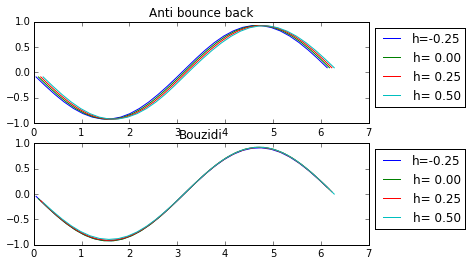

In [1]:
import numpy as np
import pylab as plt
%matplotlib inline

def mesh(N, h):
    xmin, xmax = 0., 2.*np.pi
    dx = (xmax-xmin)/N
    x = np.linspace(xmin-.5*dx+h*dx, xmax+.5*dx+h*dx, N+2)
    return x

def equilibrium(m0, c):
    return .5*c**2*m0

def initialize(mesh, c, la):
    m0 = np.sin(mesh)
    m1 = np.zeros(mesh.shape)
    m2 = equilibrium(m0, c)
    f0 = np.empty(m0.shape)
    f1 = np.empty(m0.shape)
    f2 = np.empty(m0.shape)
    return f0, f1, f2, m0, m1, m2

def f2m(f0, f1, f2, m0, m1, m2, la):
    m0[:] = f0 + f1 + f2
    m1[:] = la * (f1 - f2)
    m2[:] = .5* la**2 * (f1 + f2)

def m2f(f0, f1, f2, m0, m1, m2, la):
    f0[:] = m0 - 2./la**2 * m2
    f1[:] = .5/la * m1 + 1/la**2 * m2
    f2[:] = -.5/la * m1 + 1/la**2 * m2

def relaxation(m0, m1, m2, c, s):
    m2[:] *= (1-s)
    m2[:] += s*equilibrium(m0, c)

def transport(f0, f1, f2, bc):
    if bc == 0:
        # anti bounce back boundary conditions
        f1[0] = -f2[1]
        f2[-1] = -f1[-2]
    else:
        # Bouzidi
        # left
        s = .5+h
        if s>0.5:
            coeff = 0.5/s
            f1[0] = -coeff*f2[1] + (1.-coeff)*f1[1]
        else:
            coeff = 2.*s
            f1[0] = -coeff*f2[1] - (1.-coeff)*f2[2]
        # right
        s = .5-h
        if s>0.5:
            coeff = 0.5/s
            f2[-1] = -coeff*f1[-2] + (1.-coeff)*f2[-2]
        else:
            coeff = 2.*s
            f2[-1] = -coeff*f1[-2] - (1.-coeff)*f1[-3]
    # transport
    f1[1:-1] = f1[:-2]
    f2[1:-1] = f2[2:]

def run(h, bc):
    # initialization
    x = mesh(N, h)     # mesh
    dx = x[1]-x[0]  # space step
    dt = dx/la      # time step
    f0, f1, f2, m0, m1, m2 = initialize(x, c, la)
    # time loops
    nt = int(Tf/dt)
    m2f(f0, f1, f2, m0, m1, m2, la)
    for k in range(nt):
        transport(f0, f1, f2, bc)
        f2m(f0, f1, f2, m0, m1, m2, la)
        relaxation(m0, m1, m2, c, s)
        m2f(f0, f1, f2, m0, m1, m2, la)
    plt.plot(x[1:-1], m0[1:-1], label='h={0:5.2f}'.format(h))

# parameters
c = .5       # velocity for the transport equation
Tf = 2*np.pi # final time
N = 32       # number of points in space
la = 1.      # scheme velocity
s = 1.5      # relaxation parameter

plt.figure(1)
plt.clf()
plt.subplot(2,1,1)
for h in [-0.25, 0., 0.25, 0.5]:
    run(h, 0)
plt.title('Anti bounce back')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.subplot(2,1,2)
for h in [-0.25, 0., 0.25, 0.5]:
    run(h, 1)
plt.title('Bouzidi')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

##Comparaison on the Poiseuille flow

We then compare the bounce back condition with the Bouzidi condition in 2D. Considering the Poiseuille flow investigated in the work session 05, the domain is reduced in the $y$-direction in order to shift the bounds (and not the mesh).

####Question 1

Modify the dictionary of the work session 05 to reduce the domain $(0,1)\times(-0.5,0.5)$ into $(0,1)\times(-0.5+h,0.5-h)$.
It can be done by removing two small strips on the top and on the bottom (use the class pyLBM.Parallelogram).

We can take for instance $h=\dx/4$.

####Question 2

Modify the value of the boundary conditions to be consistant with the width of the domain:
$$q_x(x, y) = \rho_0 v_{\text{max}} \Bigl( 1 - \frac{4y^2}{(W-2h)^2} \Bigr), \qquad q_y(x, y) = 0,$$
if $h$ is the width of the removed strip.

####Question 3

Compute the solution for a space step $\dx=1/16$ at the time $Tf=50$ for these two types of boundary conditions.

####Question 4

Evaluate the position of the numerical bounds by interpolating a slice of the solution in the middle of the simulation by a polynomials of order 2. The function polyfit of the module numpy could be useful. Compare the results.

In [7]:
import sympy as sp
import numpy as np
import pyLBM

X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy = sp.symbols('rho, qx, qy')

def bc(f, m, x, y, scheme):
    m[:,1] = rhoo * vmax * (1.-4.*y**2/(W-2*h)**2)
    m[:,2] = 0.
    scheme.equilibrium(m)
    scheme.m2f(m, f)

def bound_position(sol):
    mx = int(sol.domain.N[0]/2-1)
    y = sol.domain.x[1][1:-1]
    u = sol.m[0][1][mx,1:-1] / rhoo
    P = np.polyfit(y, u, 2)
    D = np.sqrt(P[1]**2 - 4*P[0]*P[2])
    xp = (-P[1]+D)/(2*P[0])
    xm = (-P[1]-D)/(2*P[0])
    print "bottom position: {0:9.6f} (exact: {1:9.6f})".format(xp, ymin+h)
    print "top position:    {0:9.6f} (exact: {1:9.6f})".format(xm, ymax-h)
    print "relative error:  {0:10.3e}, {1:10.3e}".format((xp-ymin-h)/h, (xm-ymax+h)/h)

def create_dico(bc_func):
    dico = {
        'box':{'x':[xmin, xmax], 'y':[ymin, ymax], 'label':0},
        'elements':[
            pyLBM.Parallelogram((xmin, ymin), (xmax-xmin, 0.), (0.,h), isfluid=False, label=1),
            pyLBM.Parallelogram((xmin, ymax), (xmax-xmin, 0.), (0.,-h), isfluid=False, label=1),
        ],
        'space_step':dx,
        'scheme_velocity':la,
        'parameters':{LA:la},
        'schemes':[
            {
                'velocities':range(9),
                'conserved_moments':[rho, qx, qy],
                'polynomials':[
                    1, LA*X, LA*Y,
                    3*(X**2+Y**2)-4,
                    (9*(X**2+Y**2)**2-21*(X**2+Y**2)+8)/2,
                    3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                    X**2-Y**2, X*Y
                ],
                'relaxation_parameters':s,
                'equilibrium':[
                    rho, qx, qy,
                    -2*rho + 3*q2,
                    rho+3/2*q2,
                    -qx/LA, -qy/LA,
                    qx2-qy2, qxy
                ],
                'init':{rho:rhoo, qx:0., qy:0.},
            },
        ],
        'boundary_conditions':{
            0:{'method':{0: bc_func}, 'value':bc},
            1:{'method':{0: bc_func}, 'value':None},
        },
        'generator': pyLBM.generator.CythonGenerator,
    }
    return dico

# parameters
shift = 0.25
dx = 1./16  # spatial step
la = 1.      # velocity of the scheme
Tf = 50      # final time of the simulation
L = 1        # length of the domain
W = 1        # width of the domain
vmax = 0.1   # maximal velocity obtained in the middle of the channel
rhoo = 1.    # mean value of the density
mu = 1.e-2   # bulk viscosity
eta = 1.e-2  # shear viscosity
h = shift*dx
pressure_gradient = - vmax * 8.0 / (W-2*h)**2 * eta
# initialization
xmin, xmax, ymin, ymax = 0.0, L, -0.5*W, 0.5*W
dummy = 3.0/(la*rhoo*dx)
s_mu = 1.0/(0.5+mu*dummy)
s_eta = 1.0/(0.5+eta*dummy)
s_q = s_eta
s_es = s_mu
s  = [0.,0.,0.,s_mu,s_es,s_q,s_q,s_eta,s_eta]
dummy = 1./(LA**2*rho)
qx2 = dummy*qx**2
qy2 = dummy*qy**2
q2  = qx2+qy2
qxy = dummy*qx*qy

bc_func = pyLBM.bc.bounce_back
dico = create_dico(bc_func)
sol = pyLBM.Simulation(dico)
while (sol.t<Tf):
    sol.one_time_step()
sol.f2m()
print "Bounce back condition"
bound_position(sol)
bc_func = pyLBM.bc.bouzidi_bounce_back
dico = create_dico(bc_func)
sol = pyLBM.Simulation(dico)
while (sol.t<Tf):
    sol.one_time_step()
sol.f2m()
print "Bouzidi condition"
bound_position(sol)

Bounce back condition
bottom position: -0.496924 (exact: -0.484375)
top position:     0.496924 (exact:  0.484375)
relative error:  -8.031e-01,  8.031e-01
Bouzidi condition
bottom position: -0.485125 (exact: -0.484375)
top position:     0.485125 (exact:  0.484375)
relative error:  -4.800e-02,  4.800e-02


In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()